In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import squarify
import seaborn as sns

In [2]:
# Load the data
filepath = 'processed_data.csv'  # Replace with the actual file path
df = pd.read_csv(filepath)

In [3]:
# Inspect the data
print(df.shape)
print(df.columns)
df.head(10)

(193, 2)
Index(['Company', 'Industry'], dtype='object')


,Company,Industry
0,#67,Telephone Utilities
1,46andMix,Other
2,A_Connect,Education
3,AA,Computer Software
4,Abstract,Internet
5,Adonis,Health
6,Ahonetwo,Business Services
7,AI HR APP,Computer Software
8,AIID,"Builders/Residential, Computer Software"
9,ANAKIN,Internet


In [4]:
df.describe()

,Company,Industry
count,193,193
unique,193,72
top,#67,Other
freq,1,32


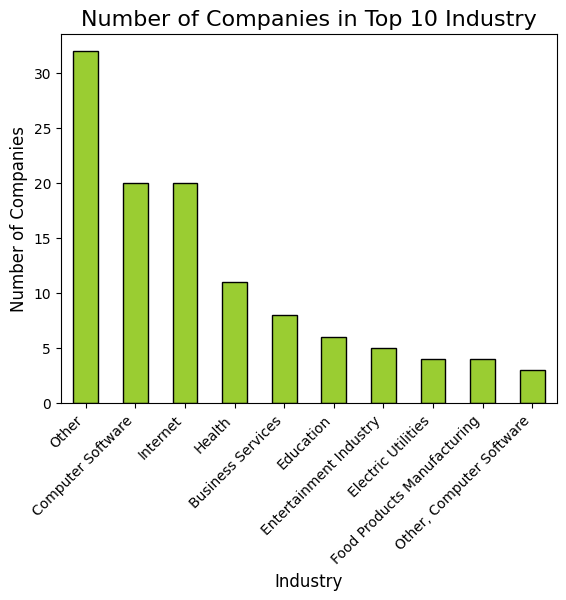

In [5]:
# Bar chart showing the number of companies in top 10 industry
industry_counts_top10 = df['Industry'].value_counts().head(10)
industry_counts_top10.plot(kind='bar', color='yellowgreen', edgecolor='black')
plt.title('Number of Companies in Top 10 Industry', fontsize=16)
plt.xlabel('Industry', fontsize=12)
plt.ylabel('Number of Companies', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

Text(0, 0.5, '')

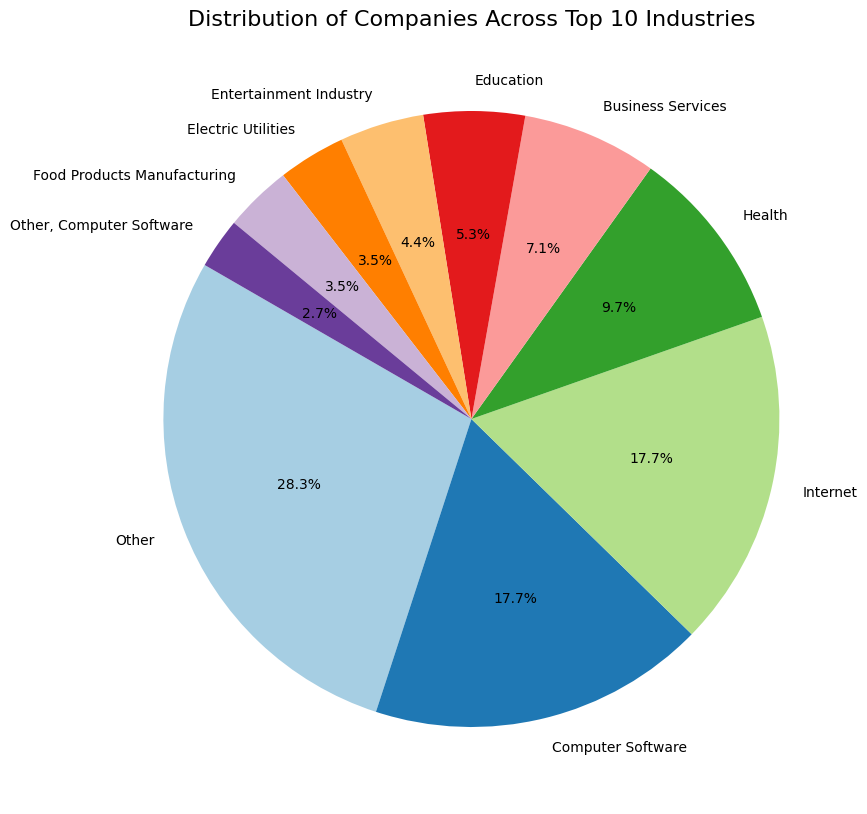

In [6]:
# Pie Chart: Percentage Distribution of Companies Across Industries
plt.figure(figsize=(10, 10))
industry_counts_top10.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=plt.cm.Paired.colors)
plt.title('Distribution of Companies Across Top 10 Industries', fontsize=16)
plt.ylabel('')  # Hides the y-label for the pie chart

(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

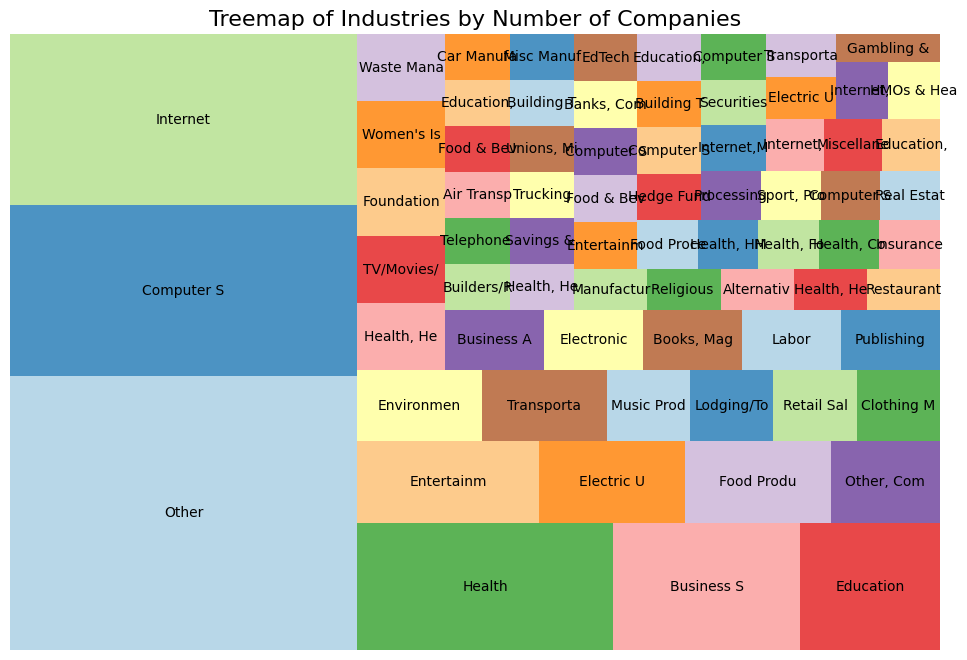

In [7]:
# Prepare data for treemap
industry_counts = df['Industry'].value_counts()
sizes = industry_counts.values
labels = industry_counts.index

# Truncate long industry names
max_label_length = 10  # Adjust as needed
labels = [label[:max_label_length] + '' if len(label) > max_label_length else label for label in labels]

# Treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=0.8, color=plt.cm.Paired.colors)
plt.title('Treemap of Industries by Number of Companies', fontsize=16)
plt.axis('off')  # Remove axes for a cleaner look

In [8]:
import networkx as nx
from collections import defaultdict

In [9]:
def create_industry_network():
    G = nx.Graph()
    industry_connections = defaultdict(int)

    for _, row in df.iterrows():
        industries = [ind.strip() for ind in row['Industry'].split(',')]
        if len(industries) > 1:
            for i in range(len(industries)):
                for j in range(i + 1, len(industries)):
                    pair = tuple(sorted([industries[i], industries[j]]))
                    industry_connections[pair] += 1

    unique_industries = set()
    for pair in industry_connections:
        unique_industries.add(pair[0])
        unique_industries.add(pair[1])

    for industry in unique_industries:
        company_count = df['Industry'].str.contains(industry).sum()
        G.add_node(industry, size=company_count)

    for (ind1, ind2), weight in industry_connections.items():
        G.add_edge(ind1, ind2, weight=weight)

    return G

In [10]:
def adjust_positions(pos, min_dist=0.1, max_iterations=50):
    pos_array = np.array([pos[node] for node in pos])

    adjusted = True
    iteration = 0

    while adjusted and iteration < max_iterations:
        iteration += 1
        adjusted = False
        dx = pos_array[:, 0, np.newaxis] - pos_array[:, 0]
        dy = pos_array[:, 1, np.newaxis] - pos_array[:, 1]
        dist = np.sqrt(dx**3 + dy**3)

        np.fill_diagonal(dist, np.inf)

        close_pairs = dist < min_dist

        for i, j in zip(*np.where(close_pairs)):
            if i < j:
                factor = (min_dist - dist[i, j]) / dist[i, j] / 2
                dx_ij, dy_ij = dx[i, j], dy[i, j]
                pos_array[i, 0] += dx_ij * factor
                pos_array[i, 1] += dy_ij * factor
                pos_array[j, 0] -= dx_ij * factor
                pos_array[j, 1] -= dy_ij * factor
                adjusted = True

    new_pos = {node: pos_array[i] for i, node in enumerate(pos)}
    return new_pos


In [11]:
def draw_network(G, save_pos_file='node_positions.npy', loading_existing=False):
    np.random.seed(42)

    # Create figure
    plt.figure(figsize=(17, 17))

    pos = nx.spring_layout(G, k=2, iterations=100, seed=42)

    pos = adjust_positions(pos)

    if loading_existing and os.path.exists(save_pos_file):
        pos = np.load(save_pos_file, allow_pickle=True).item()
    else:
        pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
        np.save(save_pos_file, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.4, edge_color='olive')

    # Draw nodes
    node_sizes = [G.nodes[node]['size'] * 200 for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='gold', alpha=0.7)

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    # Add title and remove axes
    plt.title('Industry Relationship Network', fontsize=20)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

C:\Users\JoyChang\AppData\Local\Temp\ipykernel_4836\159080671.py:12: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt(dx**3 + dy**3)


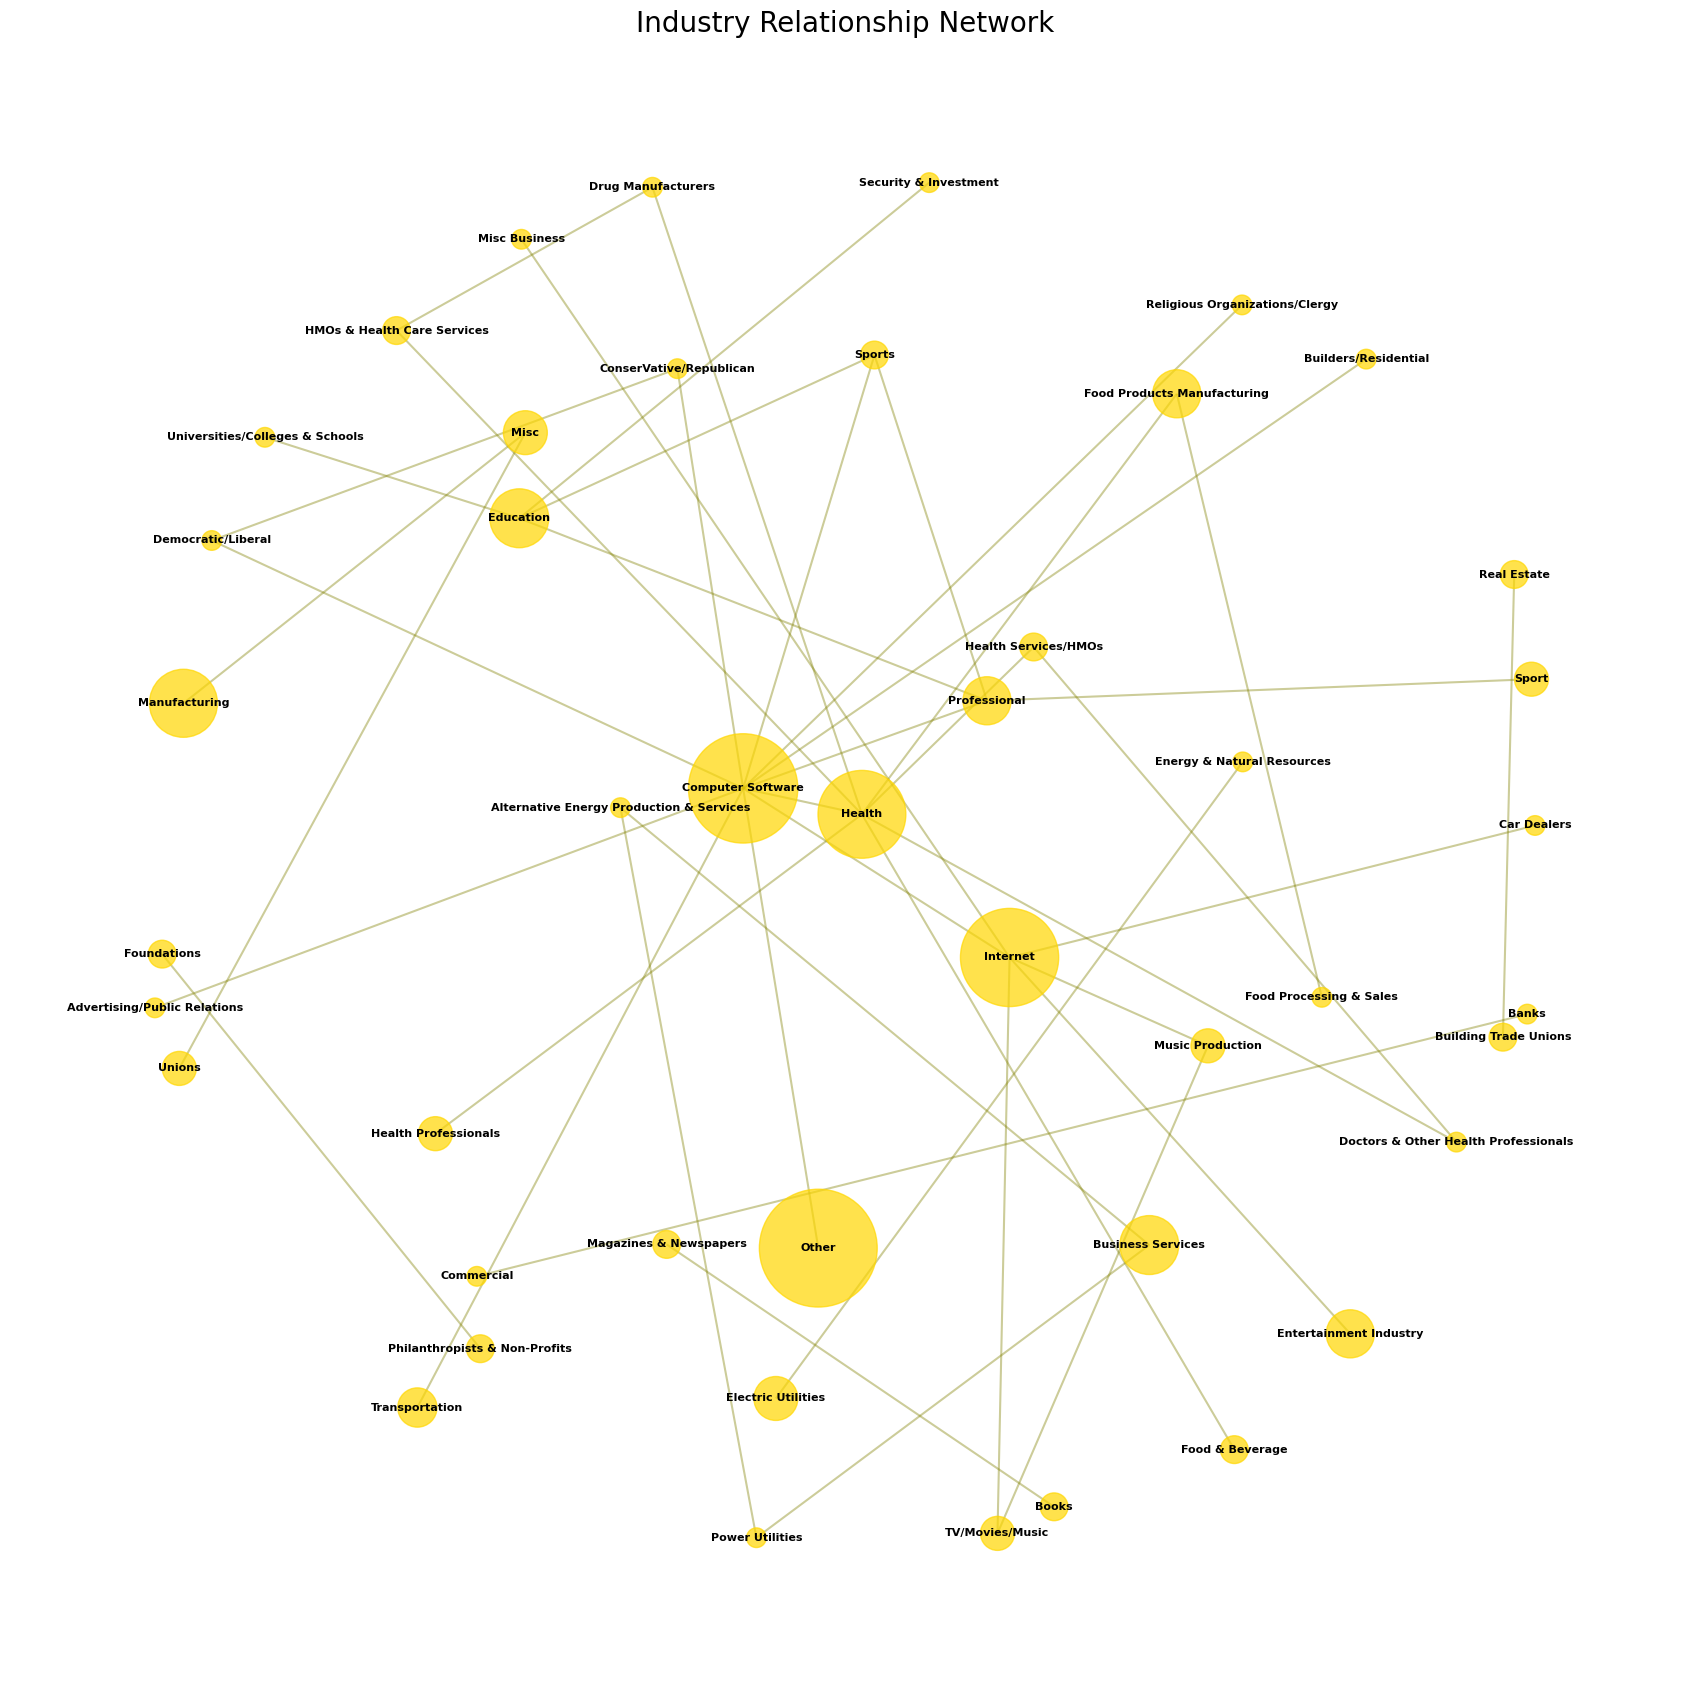

In [12]:
# Create and visualize the network
G = create_industry_network()
draw_network(G)

In [13]:
from wordcloud import WordCloud
from collections import Counter

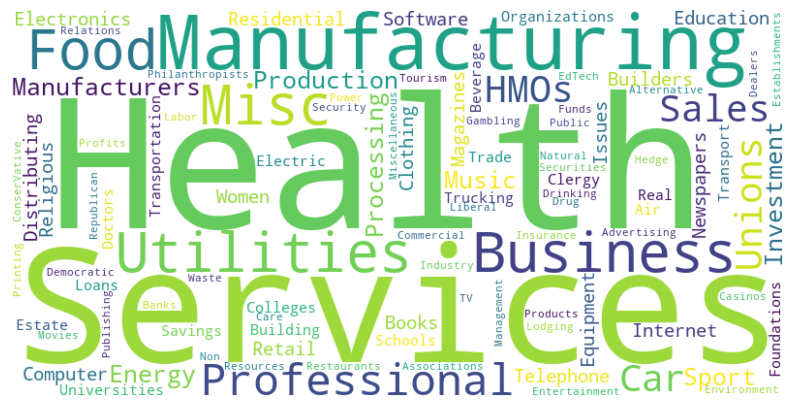

In [14]:
# Process industries
# Split industries that have multiple categories and create a flat list
all_industries = []
for industries in df['Industry'].str.split(','):
    all_industries.extend([industry.strip() for industry in industries])

# Count frequencies
industry_freq = Counter(all_industries)

# Create text for wordcloud (repeat words based on frequency)
text = ' '.join([industry + ' ' * count for industry, count in industry_freq.items()])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis_r').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
import plotly.express as px
import plotly.graph_objects as go

In [16]:
# Check and preprocess the data
df['Industry'] = df['Industry'].str.split(',')
df['Company'] = df['Company'].str.split(',')

# Prepare data for the Sunburst chart
sunburst_data = []
for _, row in df.iterrows():
    industries = row['Industry']
    companies = row['Company']

    # Create hierarchy for each company under the last industry
    for i, (industry, company) in enumerate(zip(industries, companies)):
        # Define parent as the previous level industry or the root ('All Industries')
        parent = industries[i - 1] if i > 0 else 'All Industries'
        if i == len(industries) - 1:  # If it's the last industry level, add companies
            sunburst_data.append({'ids': company.strip(), 'labels': company.strip(), 'parents': industry.strip(), 'Value': 1})
        else:  # Add industry as an intermediate node
            sunburst_data.append({'ids': industry.strip(), 'labels': industry.strip(), 'parents': parent.strip(), 'Value': 1})

# Create DataFrame for sunburst
sunburst_df = pd.DataFrame(sunburst_data)

In [26]:
fig = px.sunburst(
    sunburst_df,
    path=['parents', 'labels'],
    values='Value',
    color='labels',
    color_discrete_sequence=px.colors.qualitative.Set2_r,  # Better for categorical data
)

fig.update_traces(insidetextorientation='radial',
                  textinfo='label')

fig.update_layout(
    title={
        'text': 'Sunburst Chart of Industry Relationships',
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 25, 'color': 'black'}
    },
    margin=dict(t=90, l=10, r=10, b=10),
    width=1500,
    height=1300
)

fig.show()

The 'textinfo' property is a flaglist and may be specified
    as a string containing:
      - Any combination of ['label', 'text', 'value', 'current path', 'percent root', 'percent entry', 'percent parent'] joined with '+' characters
        (e.g. 'label+text')
        OR exactly one of ['none'] (e.g. 'none')